In [1]:
# (Optional) Install packages if missing - run only if you need to
# !pip install scikit-learn==1.7.2 matplotlib seaborn joblib scipy

import sys
import sklearn, pandas, numpy
print("python:", sys.version.splitlines()[0])
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)


python: 3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:09:58) [MSC v.1929 64 bit (AMD64)]
pandas: 2.3.3
numpy: 2.3.5
scikit-learn: 1.7.2


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import joblib
from scipy.stats import chi2_contingency
import warnings

# Optional: hide the sklearn InconsistentVersionWarning if it floods your output
from sklearn.base import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

sns.set(style="whitegrid")
%matplotlib inline

In [3]:
# DATA LOAD
DATA_PATH = "diabetes (1).csv"   # change if your filename differs
df = pd.read_csv(DATA_PATH)
print("shape:", df.shape)
df.head()

shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [21]:
# Quick EDA: info & distribution
df.info()
display(df.describe().T)

# show class balance
print("\nClass distribution:")
print(df['Outcome'].value_counts(normalize=False))

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00



Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64


In [6]:
# Cleaning: replace zeros that represent missing medically
# Columns where 0 is invalid => treat as missing and replace with median
cols_zero_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

for c in cols_zero_missing:
    n_zero = (df[c] == 0).sum()
    print(f"{c}: zeros={n_zero}, median(before)={df[c].median():.3f}")
    # replace zeros with NaN, then fill with median
    df.loc[df[c] == 0, c] = np.nan
    df[c].fillna(df[c].median(), inplace=True)

# quick sanity
(df[cols_zero_missing] == 0).sum()

Glucose: zeros=0, median(non-zero)=117.000
BloodPressure: zeros=0, median(non-zero)=72.000
SkinThickness: zeros=0, median(non-zero)=29.000
Insulin: zeros=0, median(non-zero)=125.000
BMI: zeros=0, median(non-zero)=32.300

Remaining zeros in those cols:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

Any NaNs left?
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


In [7]:
FEATURES = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
TARGET = "Outcome"

X = df[FEATURES].copy()
y = df[TARGET].copy()

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (768, 8) y shape: (768,)


In [8]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("train:", X_train.shape, "test:", X_test.shape)

train: (614, 8) test: (154, 8)


In [9]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
print("5-fold CV accuracy (train):", cv_scores.round(4))
print("CV mean:", cv_scores.mean().round(4))

5-fold CV accuracy (train): [0.7886 0.7805 0.8211 0.7805 0.7623]
CV mean: 0.7866


Test accuracy: 0.7078
Test ROC-AUC: 0.8130

Classification report:
              precision    recall  f1-score   support

           0     0.7523    0.8200    0.7847       100
           1     0.6000    0.5000    0.5455        54

    accuracy                         0.7078       154
   macro avg     0.6761    0.6600    0.6651       154
weighted avg     0.6989    0.7078    0.7008       154



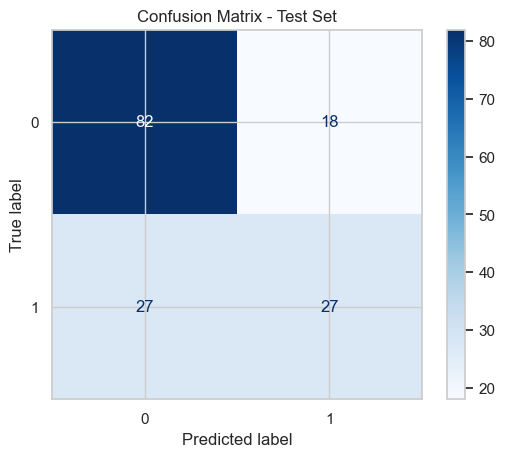

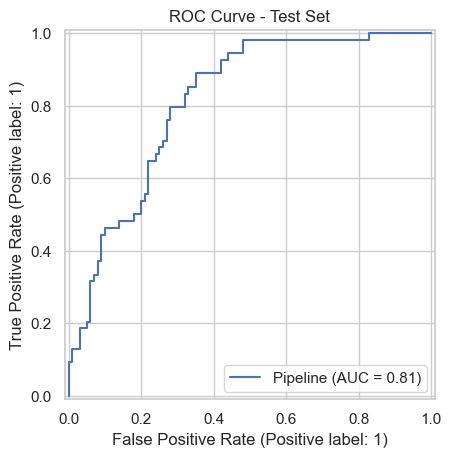

In [11]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title("ROC Curve - Test Set")
plt.show()

Glucose                     1.182511
BMI                         0.688735
Pregnancies                 0.377502
DiabetesPedigreeFunction    0.233386
Age                         0.147798
Insulin                    -0.066157
BloodPressure              -0.044066
SkinThickness               0.028225
dtype: float64

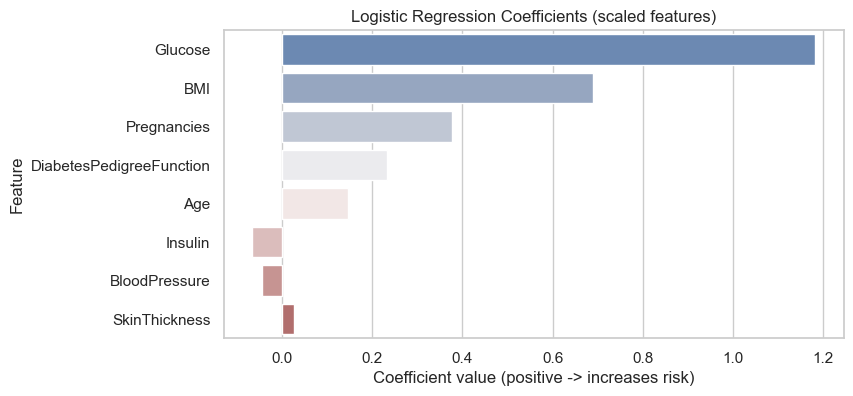

In [13]:
# Extract coefficients (logistic is linear in scaled space)
clf = pipe.named_steps['clf']
scaler = pipe.named_steps['scaler']

coefs = clf.coef_[0]
feat_imp = pd.Series(coefs, index=FEATURES).sort_values(key=lambda s: np.abs(s), ascending=False)
display(feat_imp)

# Barplot of coefficient magnitudes (signed)
plt.figure(figsize=(8,4))
sns.barplot(
    x=feat_imp.values,
    y=feat_imp.index,
    hue=feat_imp.index,     # assign hue
    palette="vlag",
    legend=False
)
plt.title("Logistic Regression Coefficients (scaled features)")
plt.xlabel("Coefficient value (positive -> increases risk)")
plt.ylabel("Feature")
plt.show()

In [14]:
# Pick a test sample index to explain (or set to -1 most recent)
i = 0
x_sample = X_test.iloc[[i]]
x_scaled = scaler.transform(x_sample)  # 1xN
contrib = (x_scaled * clf.coef_).flatten()  # contribution of each feature to z = w.x
contrib_series = pd.Series(contrib, index=FEATURES).sort_values(key=lambda s: np.abs(s), ascending=False)
intercept = clf.intercept_[0]
z = (x_scaled @ clf.coef_.T).item() + intercept
prob = 1/(1+np.exp(-z))

print("Sample index (in X_test):", X_test.index[i])
print("Linear score (z):", z)
print("Probability:", prob)
print("\nTop contributions:")
display(contrib_series)

Sample index (in X_test): 44
Linear score (z): 0.44609646206369535
Probability: 0.609710733003406

Top contributions:


Glucose                     1.472412
BMI                        -0.509764
Pregnancies                 0.362606
DiabetesPedigreeFunction   -0.129714
Age                         0.082920
BloodPressure               0.029245
Insulin                     0.010680
SkinThickness              -0.000135
dtype: float64

In [16]:
# create results table
results = X_test.copy().reset_index(drop=True)
results['Actual'] = y_test.reset_index(drop=True)
results['Predicted'] = y_pred
results['Correct'] = results['Actual'] == results['Predicted']
results['AgeGroup'] = pd.cut(results['Age'], bins=[20,30,40,50,60,70], right=True)

# per-group accuracy
gm = (
    results
    .groupby('AgeGroup', observed=False)['Correct']
    .agg(['mean','count'])
    .rename(columns={'mean':'accuracy','count':'support'})
)
display(gm)

# chi-square: contingency table of outcome vs age group (for predicted vs actual bias check use counts by group)
contingency = pd.crosstab(results['AgeGroup'], results['Predicted'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(f"\nChi-square: {chi2:.4f}, p-value: {p:.4f}, dof: {dof}")

,accuracy,support
AgeGroup,,
"(20, 30]",0.775281,89
"(30, 40]",0.592593,27
"(40, 50]",0.666667,24
"(50, 60]",0.444444,9
"(60, 70]",0.800000,5



Chi-square: 19.0095, p-value: 0.0008, dof: 4


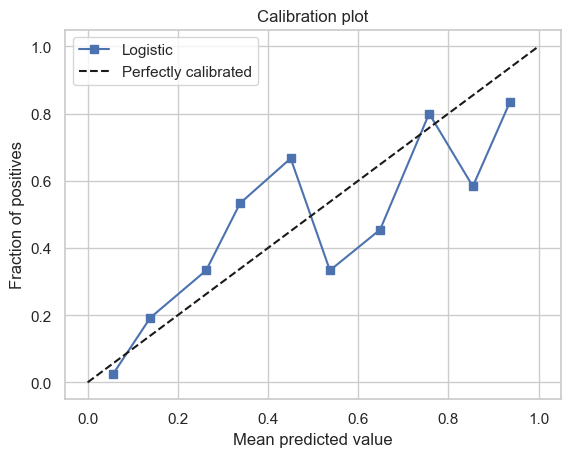

Saved calibrated model: final_model_calibrated.pkl


In [17]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Plot calibration curve
prob_pos = y_proba
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic")
plt.plot([0,1], [0,1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot")
plt.legend()
plt.show()

# If you want to calibrate:
cal = CalibratedClassifierCV(pipe, method='sigmoid', cv=5)   # or 'isotonic' if enough data
cal.fit(X_train, y_train)
joblib.dump(cal, "final_model_calibrated.pkl")
print("Saved calibrated model: final_model_calibrated.pkl")

In [18]:
# Retrain final chosen pipeline (logistic) on the entire dataset (X,y) for deployment
final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

final_pipe.fit(X, y)   # use all available data
joblib.dump(final_pipe, "final_model.pkl")
print("Saved final_model.pkl (trained on full data)")

Saved final_model.pkl (trained on full data)


In [19]:
m = joblib.load("final_model.pkl")
print("Loaded model type:", type(m))
print("Pipeline steps:", m.named_steps)
# If LogisticRegression, named_steps['clf'] should be LogisticRegression

Loaded model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: {'scaler': StandardScaler(), 'clf': LogisticRegression(max_iter=5000)}


In [20]:
sample = {
    "Pregnancies": 2,
    "Glucose": 120,
    "BloodPressure": 70,
    "SkinThickness": 20,
    "Insulin": 80,
    "BMI": 28.0,
    "DiabetesPedigreeFunction": 0.5,
    "Age": 33
}
x = pd.DataFrame([sample])[FEATURES]
prob = final_pipe.predict_proba(x)[:,1][0]
pred = final_pipe.predict(x)[0]
print(f"probability: {prob:.4f}, predicted label: {pred}")

probability: 0.1844, predicted label: 0


Saved confusion_matrix.png and roc_curve.png


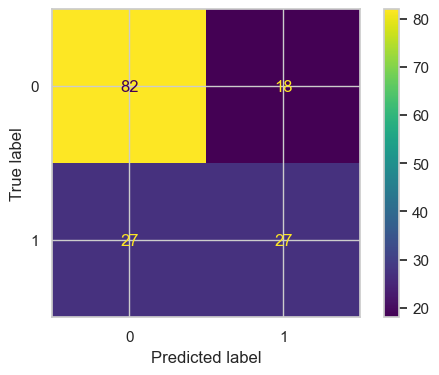

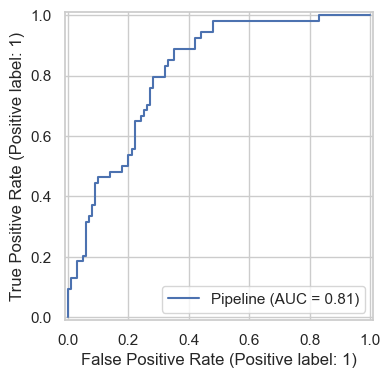

In [24]:
# Reproduce Confusion matrix and ROC and save
fig, ax = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, ax=ax)
fig.savefig("confusion_matrix.png", dpi=150, bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(6,4))
RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax2)
fig2.savefig("roc_curve.png", dpi=150, bbox_inches='tight')

print("Saved confusion_matrix.png and roc_curve.png")